In [1]:
# Import needed Libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
path = 'loan.csv' # Change the path here if different
df = pd.read_csv(path)


# Understanding the data: number of entries, columns, datatypes
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.columns.size

# Data Cleaning

## Filtering Data

In [3]:
# Keeping only data relevant for the problem statement: loan status != Current
df = df[df.loan_status != 'Current']
df.reset_index(drop=True,inplace=True)

## Removing unnecessary columns

In [4]:
# Listing columns with No values or all values are missing
df.dropna(axis=1,how='all',inplace=True)

#Dropping insignificant Columns
df.drop(columns=['desc','url','title'],inplace=True)

#Dropping columns with >50% NA values
df.drop(columns=['mths_since_last_delinq','mths_since_last_record'],inplace=True)

# Dropping Columns with only one unique value
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)
df.columns.size

40

## Fixing data types

In [5]:
# Removing % 
df.int_rate = df.int_rate.apply(lambda x : float(x.replace('%','')))
df.revol_util = df.revol_util.apply(lambda x : float(str(x).replace('%','')))

In [6]:
def correct_years_beyong_1969(dt):
    current_year = pd.to_datetime('now').year
    if dt.year > current_year:
        dt = dt.replace(year=dt.year-100)
    return dt

In [7]:
# Converting dates in string format to datetime format of pandas
current_year = pd.to_datetime('now').year
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%y').apply(lambda x : correct_years_beyong_1969(x))
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line,format='%b-%y').apply(lambda x : correct_years_beyong_1969(x))
df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d,format='%b-%y').apply(lambda x : correct_years_beyong_1969(x))
df.last_credit_pull_d = pd.to_datetime(df.last_credit_pull_d,format='%b-%y').apply(lambda x : correct_years_beyong_1969(x))

## Fix Missing Values

In [ ]:
missing_values = df.isna().any()
missing_values[missing_values == True]

# Intermediate data separation

In [9]:
df.to_csv('filtered_data.csv')

In [8]:
print(list(df.columns))

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'pub_rec_bankruptcies']


In [10]:
df_co =  df[df.loan_status == 'Charged Off']
df_fp = df[df.loan_status == 'Fully Paid']

# Univariate Analysis

In [ ]:
# id, member_id are unique. It doesn't make sense to do univariate analysis on those columns
# Univariate analysis on loan_amnt
plt.boxplot(df.loan_amnt)
plt.ylabel('Loan Amount')
plt.xticks([1],['Loan Applicants'])
plt.title('Loan Amount Distribution')
plt.show()

In [ ]:
# Univariate analysis on funded_amnt
plt.boxplot(df.funded_amnt)
plt.ylabel('Funded Amount')
plt.xticks([1],['Loan Applicants'])
plt.title('Funded Amount Distribution')
plt.show()

In [ ]:
# Univariate analysis on funded_amnt_inv
plt.boxplot(df.funded_amnt_inv)
plt.ylabel('Funded Amount Investors')
plt.xticks([1],['Loan Applicants'])
plt.title('Funded Amount by Investors Distribution')
plt.show()

In [ ]:
# Univariate analysis on term
df.term.value_counts().sort_index().plot.bar()
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Loan Term')
plt.show()

In [ ]:
# Univariate analysis on int_rate
plt.boxplot(df.int_rate)
plt.ylabel('Interest Rate in %')
plt.xticks([1],['Loan Applicants'])
plt.title('Interest Rate Distribution')
plt.show()

In [ ]:
# Univariate analysis on installment
plt.boxplot(df.installment)
plt.ylabel('Installment amount')
plt.xticks([1],['Loan Applicants'])
plt.title('Installment Amount Distribution')
plt.show()

In [ ]:
# Univariate analysis on Loan Grade
df.grade.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Loan Grade')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Loan Grade')
plt.show()

In [ ]:
# Univariate analysis on Loan Sub Grade
df.sub_grade.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Loan Sub Grade')
plt.title('Frequency Distribution of Loan Sub Grade')
plt.show()

## TODO Adjust the Fig Size Later

In [ ]:
# df.emp_title.value_counts().plot.bar()
# plt.ylabel('Frequency')
# plt.xticks(rotation=0)
# plt.title('Frequency Distribution of Borrower\'s emp title')
# plt.show()
# TODO

In [ ]:
# Univariate analysis on Employment Length
df.emp_length.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Employment Length in years')
plt.title('Frequency Distribution of Borrower\'s Employment Length')
plt.show()

# TODO Missing value imputation for emp_length

In [ ]:
# Univariate analysis on Home Ownership
df.home_ownership.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Home Ownership Status')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Home Ownership Status')
plt.show()

In [ ]:
# Univariate analysis on annual_inc
plt.boxplot(df.annual_inc)
plt.ylabel('Annual Income')
plt.xticks([1],['Loan Applicants'])
plt.title('Annual Income Distribution')
plt.show()

In [ ]:
# Univariate analysis on Verification Status
df.verification_status.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Verification Status')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Verification Status')
plt.show()


In [ ]:
# Univariate analysis on Issue date
df.issue_d.dt.year.value_counts().sort_index().plot.bar()
plt.ylabel('Loans Issued')
plt.xlabel('Issuing Year')
plt.xticks(rotation=0)
plt.title('Distribution of Loans Issued across years')
plt.show()

In [ ]:
# Univariate analysis on Purpose
df.purpose.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Purpose')
plt.show()

In [ ]:
# Univariate analysis on State
df.addr_state.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.title('Frequency Distribution of State')
plt.show()

#TODO figure size issue fix

In [ ]:
# Univariate analysis on dti
plt.boxplot(df.dti)
plt.ylabel('Debt to Income Ratio')
plt.xticks([1],['Loan Applicants'])
plt.title('Debt to Income Ratio Distribution')
plt.show()

In [ ]:
# Univariate analysis on delinq_2yrs
df.delinq_2yrs.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Deliquent Incidences in 2 years')
plt.xticks(rotation=90)
plt.title('Frequency Distribution across Deliquent Incidences in 2 years ')
plt.show()

In [ ]:
# Univariate analysis on Earliest Credit Line
df.earliest_cr_line.dt.year.plot.hist(edgecolor='white',color='brown',bins=10)
plt.ylabel('Frequency')
plt.xlabel('Year of Earliest LOC')
plt.xticks(rotation=0)
plt.title('Frequency Distribution w.r.t Earliest LOC')
plt.show()


In [ ]:
# Univariate analysis on Number of Inquiries in the last 6 months
df.inq_last_6mths.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Number of Inquiries in the last 6 months')
plt.xticks(rotation=0)
plt.title('Frequency Distribution across Number of Inquiries in the last 6 months')
plt.show()

In [ ]:
# Univariate analysis on Open Credit Lines
plt.boxplot(df.open_acc)
plt.ylabel('Open Credit Lines')
plt.xticks([1],['Loan Applicants'])
plt.title('Open Credit Lines Distribution')
plt.show()

In [ ]:
# Univariate analysis on Public Records
df.pub_rec.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Public Records')
plt.xticks(rotation=0)
plt.title('Frequency Distribution across Public Records')
plt.show()

In [ ]:
# Univariate analysis on Revolving Balance
plt.boxplot(df.revol_bal)
plt.ylabel('Revolving Balance')
plt.xticks([1],['Loan Applicants'])
plt.title('Revolving Balance Distribution')
plt.show()

In [ ]:
# Univariate analysis on Revolving Line Util. Rate
df.revol_util.plot.hist(edgecolor='white',color='brown',bins=50)
plt.ylabel('Frequency')
plt.xlabel('Revolving Line Util Rate')
plt.xticks(rotation=0)
plt.title('Frequency Distribution w.r.t Revolving Line Util Rate')
plt.show()


In [ ]:
# Univariate analysis on Total Credit Lines
plt.boxplot(df.total_acc)
plt.ylabel('Total Credit Lines')
plt.xticks([1],['Loan Applicants'])
plt.title('Total Credit Lines Distribution')
plt.show()

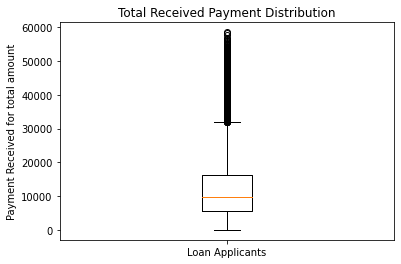

In [12]:
# Univariate analysis on Payment Received for total amnt
plt.boxplot(df.total_pymnt)
plt.ylabel('Payment Received for total amount')
plt.xticks([1],['Loan Applicants'])
plt.title('Total Received Payment Distribution')
plt.show()

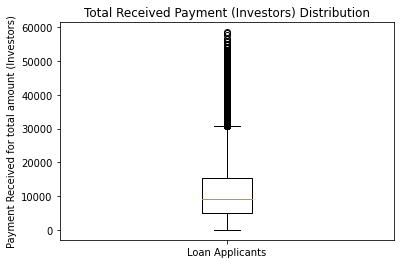

In [14]:
# Univariate analysis on Payment Received for total amnt by investors
plt.boxplot(df.total_pymnt_inv)
plt.ylabel('Payment Received for total amount (Investors)')
plt.xticks([1],['Loan Applicants'])
plt.title('Total Received Payment (Investors) Distribution')
plt.show()

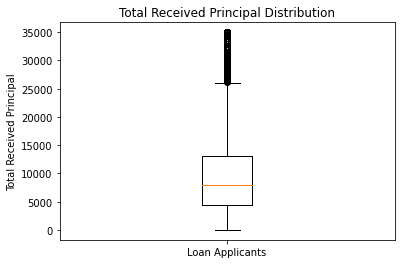

In [17]:
# Univariate analysis on Total Received Principal
plt.boxplot(df.total_rec_prncp)
plt.ylabel('Total Received Principal')
plt.xticks([1],['Loan Applicants'])
plt.title('Total Received Principal Distribution')
plt.show()

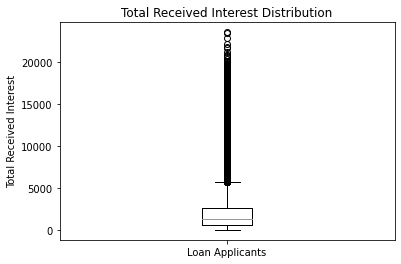

In [18]:
# Univariate analysis on Total Received Interest
plt.boxplot(df.total_rec_int)
plt.ylabel('Total Received Interest')
plt.xticks([1],['Loan Applicants'])
plt.title('Total Received Interest Distribution')
plt.show()

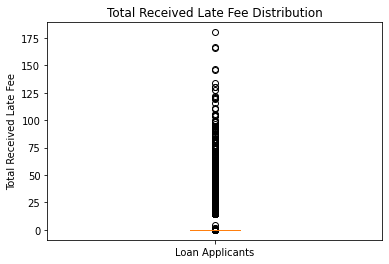

In [20]:
# Univariate analysis on Total Received Late Fee
plt.boxplot(df.total_rec_late_fee)
plt.ylabel('Total Received Late Fee')
plt.xticks([1],['Loan Applicants'])
plt.title('Total Received Late Fee Distribution')
plt.show()

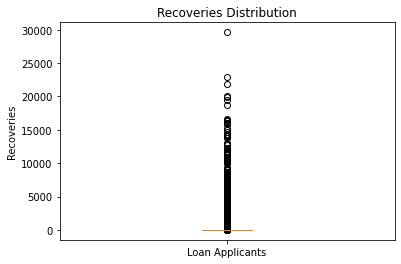

In [21]:
# Univariate analysis on recoveries
plt.boxplot(df.recoveries)
plt.ylabel('Recoveries')
plt.xticks([1],['Loan Applicants'])
plt.title('Recoveries Distribution')
plt.show()

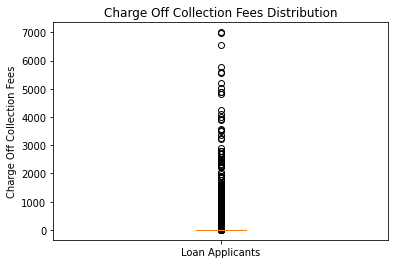

In [22]:
# Univariate analysis on Charge Off Collection Fees
plt.boxplot(df.collection_recovery_fee)
plt.ylabel('Charge Off Collection Fees')
plt.xticks([1],['Loan Applicants'])
plt.title('Charge Off Collection Fees Distribution')
plt.show()

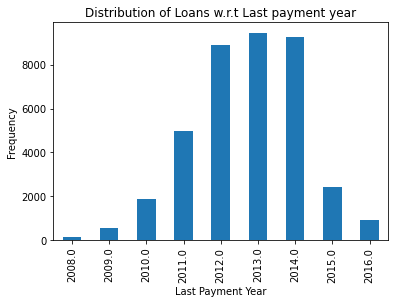

In [31]:
# Univariate analysis on Last Payment date
df.last_pymnt_d.dt.year.value_counts().sort_index().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Last Payment Year')
plt.xticks(rotation=90)
plt.title('Distribution of Loans w.r.t Last payment year')
plt.show()

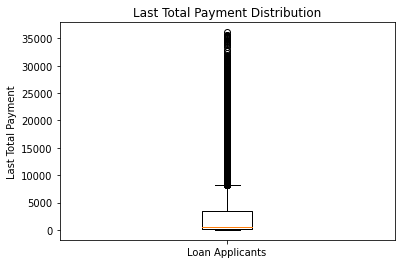

In [32]:
# Univariate analysis on Last Total Payment
plt.boxplot(df.last_pymnt_amnt)
plt.ylabel('Last Total Payment')
plt.xticks([1],['Loan Applicants'])
plt.title('Last Total Payment Distribution')
plt.show()

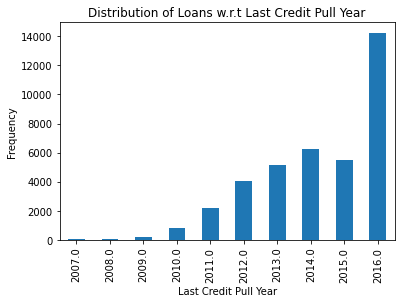

In [33]:
# Univariate analysis on Last Credit Pull Year
df.last_credit_pull_d.dt.year.value_counts().sort_index().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Last Credit Pull Year')
plt.xticks(rotation=90)
plt.title('Distribution of Loans w.r.t Last Credit Pull Year')
plt.show()

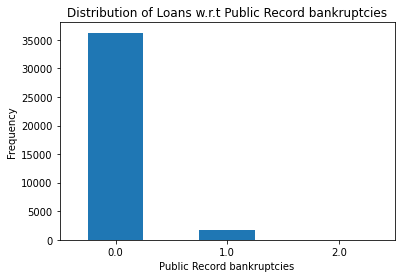

In [40]:
# Univariate analysis on Public Record bankruptcies
df.pub_rec_bankruptcies.value_counts().sort_index().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Public Record bankruptcies')
plt.xticks(rotation=0)
plt.title('Distribution of Loans w.r.t Public Record bankruptcies')
plt.show()

# Segmented Univariate Analysis

In [ ]:
print(list(df.columns))

In [ ]:
# id, member_id are unique. It doesn't make sense to do Segmented univariate analysis on those columns
# Segmented Univariate analysis on loan_amnt
fig, ax = plt.subplots()
ax.boxplot([df_co.loan_amnt,df_fp.loan_amnt])
plt.xticks([1,2],['Charged Off','Fully Paid'])
plt.show()

In [ ]:
# Univariate analysis on funded_amnt
fig, ax = plt.subplots()
ax.boxplot([df_co.funded_amnt,df_fp.funded_amnt])
plt.xticks([1,2],['Charged Off','Fully Paid'])
plt.show()

In [ ]:
# Univariate analysis on funded_amnt_inv
fig, ax = plt.subplots()
ax.boxplot([df_co.funded_amnt_inv,df_fp.funded_amnt_inv])
plt.xticks([1,2],['Charged Off','Fully Paid'])
plt.show()

In [ ]:
# Univariate analysis on term
fig, ax = plt.subplots()
plt.bar(df_co.term)
# plt.xticks([0,1],['Charged Off','Fully Paid'])
plt.show()

# Bivariate Analysis